# Segmentation Task 

### 1. Imports

In [1]:
import rasterio
from rasterio.plot import show

In [4]:
import cv2
import numpy as np
import os
import random
import torch
from torch.utils.data import DataLoader, Dataset
from torch import nn
from tqdm import tqdm
import random
from tifffile import imread

import matplotlib.pyplot as plt

C:\Users\Vedaant Joshi\anaconda3\envs\vi\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
src = rasterio.open('./dlt_32N_07/images/32N-12E-230N_01_15/07.tif')
label = rasterio.open('./dlt_32N_07/labels/32N-12E-230N_01_15/dlt.tif')

image = src.read()
label = label.read()

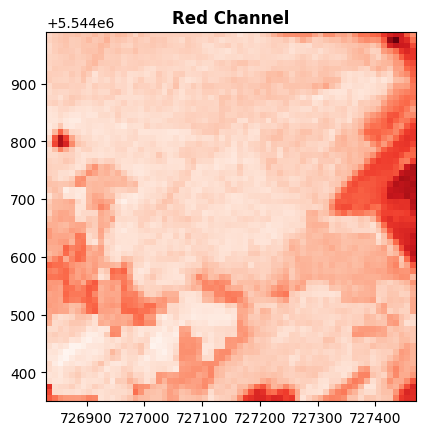

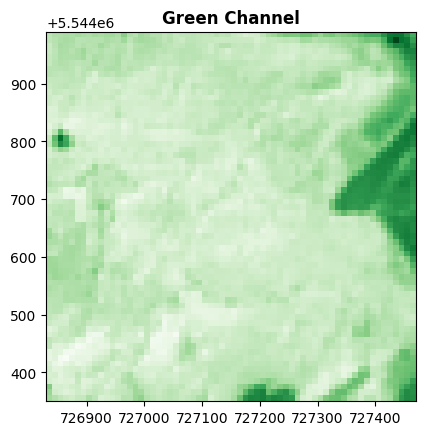

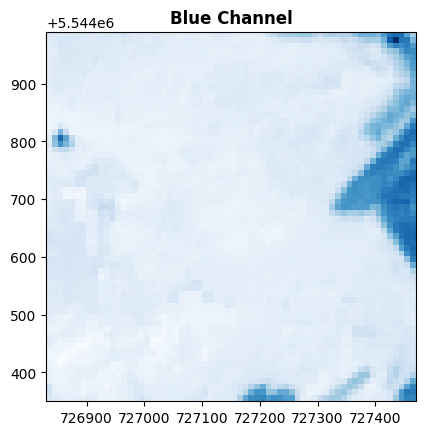

<Axes: title={'center': 'Blue Channel'}>

In [3]:
show((src, 3), cmap='Reds', title='Red Channel')
show((src, 2), cmap='Greens', title='Green Channel')
show((src, 1), cmap='Blues', title='Blue Channel')

### 2. Setting the Seed

In [5]:
def torch_seed(seed=0):
    '''
    Setting all the necessary values to generate reproducible results after training. 
    Parameter : seed (seed value)
    '''

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.cuda.manual_seed_all(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

In [6]:
torch_seed(42)

### 3. Setup Configurations

In [7]:
data_path = './dlt_32N_07/'

images_path = data_path + 'images/'
labels_path = data_path + 'labels/'

images_folder_list = os.listdir(images_path)
labels_folder_list = os.listdir(labels_path)

model_path = './models/'

In [8]:
EPOCHS = 50
LR = 0.01
DEVICE = 'cuda'
BATCH_SIZE = 16

loss_function = nn.CrossEntropyLoss()

"""
in_channels = 12 for training based on multispectral image input
in_channels = 3 for training based on rgb image input
"""
in_channels = 3

# set the path to save the plots.
image_path = './test_output/' + 'rgb/' if in_channels == 3 else 'multispectral/'

### 4. Helper Functions

In [9]:
def read_image(images_path, labels_path, index):
    
    image = os.path.join(images_path, images_folder_list[index], '07.tif')
    label = os.path.join(labels_path, labels_folder_list[index], 'dlt.tif')
    
    img = rasterio.open(image).read().transpose((1,2,0))
    label = rasterio.open(label).read()
    
    return img, label

def rgb_image_preprocessing(img):
    
    rgb_image = img[:,:,[3,2,1]]
    rgb_image = np.int16(rgb_image)
    rgb_image = np.clip(rgb_image,0,1500)
    rgb_image = rgb_image/1500 * 255
    rgb_image = np.float32(rgb_image)
    return rgb_image.transpose(2,0,1)

def multispectral_image_preprocessing(img):
    img = img[:,:,:]
    img = np.int16(img)
    img = np.clip(img,0,1500)
    img = img/1500 * 255
    img = np.float32(img)
    return img.transpose(2,0,1)

def visualize_label(num_class, color_dict, img):
    img = img[:,:,0] if len(img.shape) == 3 else img
    img_out = np.zeros((64, 64, 3))
    
    for i in range(num_class):
        img_out[img == i, :] = np.asarray(color_dict[i])
        
    return img_out

color_dict = {
    0: [0, 0, 255],
    1: [255, 255, 0],
    2: [0, 255, 0],
}

In [10]:
image,label = read_image(images_path,labels_path, 0)
num_classes = len(np.unique(label))  # No of classes for segmentation

label = visualize_label(num_classes, color_dict, label.squeeze(0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


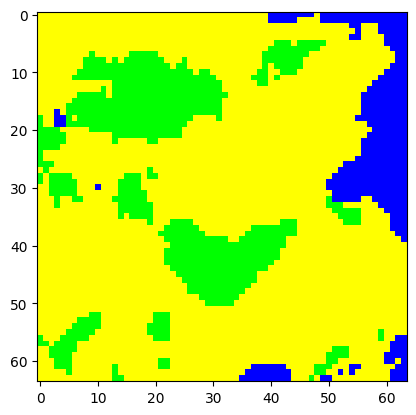

In [11]:
plt.imshow(label)

### Creating Custom Dataset

In [12]:
train, valid, test = np.split(images_folder_list, [int(len(images_folder_list)*0.8), int(len(images_folder_list)*0.9)])

In [13]:
len(train), len(valid), len(test)

(4548, 569, 569)

In [14]:
class SegmentationDataset(Dataset):
    
    def __init__(self, data_path, images_ids):
        self.images_path = data_path + 'images'
        self.labels_path = data_path + 'labels'
        
        self.images_ids = images_ids
        
    def __len__(self):
        return len(self.images_ids)
    
    def __getitem__(self, idx):
        
        image = os.path.join(self.images_path, self.images_ids[idx],'07.tif')
        label = os.path.join(self.labels_path, self.images_ids[idx],'dlt.tif')
        
        image = imread(image)
        label = imread(label)
        
        label[label==255] = 0
        
        # Data Preprocesing for multi spectral images OR rgb images
        if in_channels == 3:
            image = rgb_image_preprocessing(image)
        elif in_channels == 12:
            image = multispectral_image_preprocessing(image)
        
        image = torch.tensor(image)
        label = torch.tensor(label)
        
        return image, label

In [15]:
train_dataset = SegmentationDataset(data_path, train)
valid_dataset = SegmentationDataset(data_path, valid)
test_dataset = SegmentationDataset(data_path, test)

train_loader = DataLoader(train_dataset, batch_size = 16, shuffle = True, drop_last=True)
valid_loader = DataLoader(valid_dataset, batch_size = 16, drop_last = True)
test_loader = DataLoader(test_dataset, batch_size=16, drop_last = True)

In [16]:
image, label = next(iter(train_loader))
image.shape, label.shape

(torch.Size([16, 3, 64, 64]), torch.Size([16, 64, 64]))

### Model

In [17]:
class UNET(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv1 = self.contract_block(in_channels, 32, 7, 3)
        self.conv2 = self.contract_block(32, 64, 3, 1)
        self.conv3 = self.contract_block(64, 128, 3, 1)

        self.upconv3 = self.expand_block(128, 64, 3, 1)
        self.upconv2 = self.expand_block(64*2, 32, 3, 1)
        self.upconv1 = self.expand_block(32*2, out_channels, 3, 1)

    def __call__(self, x):

        # downsampling part
        conv1 = self.conv1(x)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)

        upconv3 = self.upconv3(conv3)

        upconv2 = self.upconv2(torch.cat([upconv3, conv2], 1))
        upconv1 = self.upconv1(torch.cat([upconv2, conv1], 1))

        return upconv1

    def contract_block(self, in_channels, out_channels, kernel_size, padding):

        contract = nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
                                 )

        return contract

    def expand_block(self, in_channels, out_channels, kernel_size, padding):

        expand = nn.Sequential(torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.Conv2d(out_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1) 
                            )
        return expand

In [18]:
unet = UNET(in_channels, num_classes)

### 7. Training

#### 7.1 Train & Validation functions

In [19]:
def train(model, dataloader, epochs, optimizer, loss_fn):
    model.to(DEVICE)
    model.train()
    train_running_loss = 0.0
    
    for iter, (image, label) in enumerate(dataloader):

        image = image.to(DEVICE)
        label = label.to(DEVICE)

        optimizer.zero_grad()
        
        output = model(image)
        loss = loss_function(output,label.long())
        
        if iter%100 == 0:
            print("Train epochs: "+str(epochs)+" Iteration: "+str(iter)+" loss: "+str(loss.item()))

        train_running_loss += loss.item()
        loss.backward()
        optimizer.step()

    return train_running_loss/len(dataloader)

def val(model, dataloader, epochs, loss_fn):
    
    model.to(DEVICE)
    model.eval()
    val_running_loss = 0.0
    
    for iter, (image, label) in enumerate(dataloader):
        
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        output = model(image)
        loss = loss_function(output,label.long())
        
        if iter%100 == 0:
            print("Val epochs: "+str(epochs)+" Iteration: "+str(iter)+" loss: "+str(loss.item()))

        val_running_loss += loss.item()

    return val_running_loss/len(dataloader)

#### 7.2 Training loop

In [97]:
min_loss = np.inf
optimizer = torch.optim.Adam(unet.parameters(), lr=LR)

for epoch in tqdm(range(EPOCHS)):
    train_loss = train(unet, train_loader, epoch, optimizer, loss_function)
    val_loss = val(unet, valid_loader, epoch, loss_function)
   
    if (val_loss < min_loss):
        min_loss = val_loss
        checkpoint = {
            "state_dict" : unet.state_dict(),
            "Val Loss" : val_loss
        }
        torch.save(checkpoint,"./models/unet_model_rgb_input.pth.tar")

  0%|                                                   | 0/50 [00:00<?, ?it/s]

Train epochs: 0 Iteration: 0 loss: 1.0718060731887817
Train epochs: 0 Iteration: 100 loss: 0.5403150320053101
Train epochs: 0 Iteration: 200 loss: 0.5054919719696045
Val epochs: 0 Iteration: 0 loss: 0.8997904062271118


  2%|▊                                          | 1/50 [00:16<13:04, 16.02s/it]

Train epochs: 1 Iteration: 0 loss: 0.5173189043998718
Train epochs: 1 Iteration: 100 loss: 0.5527707934379578
Train epochs: 1 Iteration: 200 loss: 0.5792158842086792
Val epochs: 1 Iteration: 0 loss: 0.7665858864784241


  4%|█▋                                         | 2/50 [00:33<13:19, 16.65s/it]

Train epochs: 2 Iteration: 0 loss: 0.47433456778526306
Train epochs: 2 Iteration: 100 loss: 0.49716150760650635
Train epochs: 2 Iteration: 200 loss: 0.4938006103038788
Val epochs: 2 Iteration: 0 loss: 0.9126262068748474


  6%|██▌                                        | 3/50 [00:50<13:24, 17.12s/it]

Train epochs: 3 Iteration: 0 loss: 0.4946374297142029
Train epochs: 3 Iteration: 100 loss: 1.0111368894577026
Train epochs: 3 Iteration: 200 loss: 0.47454750537872314
Val epochs: 3 Iteration: 0 loss: 0.6517736911773682


  8%|███▍                                       | 4/50 [01:08<13:19, 17.37s/it]

Train epochs: 4 Iteration: 0 loss: 0.443686842918396
Train epochs: 4 Iteration: 100 loss: 0.6741651296615601
Train epochs: 4 Iteration: 200 loss: 0.46422868967056274
Val epochs: 4 Iteration: 0 loss: 1.0832282304763794


 10%|████▎                                      | 5/50 [01:26<13:08, 17.53s/it]

Train epochs: 5 Iteration: 0 loss: 0.4944235384464264
Train epochs: 5 Iteration: 100 loss: 0.39835745096206665
Train epochs: 5 Iteration: 200 loss: 0.5178271532058716
Val epochs: 5 Iteration: 0 loss: 0.6387248039245605


 12%|█████▏                                     | 6/50 [01:44<12:57, 17.67s/it]

Train epochs: 6 Iteration: 0 loss: 0.4125846326351166
Train epochs: 6 Iteration: 100 loss: 0.47868379950523376
Train epochs: 6 Iteration: 200 loss: 0.6189828515052795
Val epochs: 6 Iteration: 0 loss: 0.8003168702125549


 14%|██████                                     | 7/50 [02:02<12:46, 17.82s/it]

Train epochs: 7 Iteration: 0 loss: 0.48817723989486694
Train epochs: 7 Iteration: 100 loss: 0.45828527212142944
Train epochs: 7 Iteration: 200 loss: 0.44188764691352844
Val epochs: 7 Iteration: 0 loss: 0.9791402220726013


 16%|██████▉                                    | 8/50 [02:20<12:35, 17.99s/it]

Train epochs: 8 Iteration: 0 loss: 0.5819993615150452
Train epochs: 8 Iteration: 100 loss: 0.42023786902427673
Train epochs: 8 Iteration: 200 loss: 0.4211692214012146
Val epochs: 8 Iteration: 0 loss: 0.7996726036071777


 18%|███████▋                                   | 9/50 [02:38<12:18, 18.02s/it]

Train epochs: 9 Iteration: 0 loss: 0.38872310519218445
Train epochs: 9 Iteration: 100 loss: 0.5634094476699829
Train epochs: 9 Iteration: 200 loss: 0.39092910289764404
Val epochs: 9 Iteration: 0 loss: 1.29719877243042


 20%|████████▍                                 | 10/50 [02:58<12:25, 18.64s/it]

Train epochs: 10 Iteration: 0 loss: 0.4696280062198639
Train epochs: 10 Iteration: 100 loss: 0.46336233615875244
Train epochs: 10 Iteration: 200 loss: 0.4727003574371338
Val epochs: 10 Iteration: 0 loss: 1.197453498840332


 22%|█████████▏                                | 11/50 [03:17<12:09, 18.71s/it]

Train epochs: 11 Iteration: 0 loss: 0.504886269569397
Train epochs: 11 Iteration: 100 loss: 0.4438277781009674
Train epochs: 11 Iteration: 200 loss: 0.5972539782524109
Val epochs: 11 Iteration: 0 loss: 0.7270083427429199


 24%|██████████                                | 12/50 [03:36<11:46, 18.60s/it]

Train epochs: 12 Iteration: 0 loss: 0.47181400656700134
Train epochs: 12 Iteration: 100 loss: 0.5084288120269775
Train epochs: 12 Iteration: 200 loss: 0.8624292612075806
Val epochs: 12 Iteration: 0 loss: 0.6739001274108887


 26%|██████████▉                               | 13/50 [03:54<11:30, 18.65s/it]

Train epochs: 13 Iteration: 0 loss: 0.3572171926498413
Train epochs: 13 Iteration: 100 loss: 0.5155260562896729
Train epochs: 13 Iteration: 200 loss: 0.39396944642066956
Val epochs: 13 Iteration: 0 loss: 1.0656183958053589


 28%|███████████▊                              | 14/50 [04:13<11:11, 18.65s/it]

Train epochs: 14 Iteration: 0 loss: 0.3940105140209198
Train epochs: 14 Iteration: 100 loss: 0.3816450536251068
Train epochs: 14 Iteration: 200 loss: 0.45575150847435
Val epochs: 14 Iteration: 0 loss: 0.5814380049705505


 30%|████████████▌                             | 15/50 [04:36<11:40, 20.01s/it]

Train epochs: 15 Iteration: 0 loss: 0.524134635925293
Train epochs: 15 Iteration: 100 loss: 0.41463732719421387
Train epochs: 15 Iteration: 200 loss: 0.3894204795360565
Val epochs: 15 Iteration: 0 loss: 0.7798414826393127


 32%|█████████████▍                            | 16/50 [04:59<11:49, 20.86s/it]

Train epochs: 16 Iteration: 0 loss: 0.6644469499588013
Train epochs: 16 Iteration: 100 loss: 0.46921205520629883
Train epochs: 16 Iteration: 200 loss: 0.41541534662246704
Val epochs: 16 Iteration: 0 loss: 0.8117740750312805


 34%|██████████████▎                           | 17/50 [05:27<12:35, 22.90s/it]

Train epochs: 17 Iteration: 0 loss: 0.5041938424110413
Train epochs: 17 Iteration: 100 loss: 0.36465713381767273
Train epochs: 17 Iteration: 200 loss: 0.6646332740783691
Val epochs: 17 Iteration: 0 loss: 0.7219852209091187


 36%|███████████████                           | 18/50 [05:53<12:45, 23.93s/it]

Train epochs: 18 Iteration: 0 loss: 0.37365931272506714
Train epochs: 18 Iteration: 100 loss: 0.5246146321296692
Train epochs: 18 Iteration: 200 loss: 0.3209604322910309
Val epochs: 18 Iteration: 0 loss: 0.9693944454193115


 38%|███████████████▉                          | 19/50 [06:19<12:44, 24.68s/it]

Train epochs: 19 Iteration: 0 loss: 0.34965935349464417
Train epochs: 19 Iteration: 100 loss: 0.5563642382621765
Train epochs: 19 Iteration: 200 loss: 0.37215402722358704
Val epochs: 19 Iteration: 0 loss: 0.6180607080459595


 40%|████████████████▊                         | 20/50 [06:46<12:40, 25.33s/it]

Train epochs: 20 Iteration: 0 loss: 0.44609037041664124
Train epochs: 20 Iteration: 100 loss: 0.34843623638153076
Train epochs: 20 Iteration: 200 loss: 0.46391791105270386
Val epochs: 20 Iteration: 0 loss: 0.6478779315948486


 42%|█████████████████▋                        | 21/50 [07:13<12:25, 25.71s/it]

Train epochs: 21 Iteration: 0 loss: 0.4595377743244171
Train epochs: 21 Iteration: 100 loss: 0.4601818323135376
Train epochs: 21 Iteration: 200 loss: 0.35477617383003235
Val epochs: 21 Iteration: 0 loss: 0.9418078660964966


 44%|██████████████████▍                       | 22/50 [07:39<12:01, 25.77s/it]

Train epochs: 22 Iteration: 0 loss: 0.42147254943847656
Train epochs: 22 Iteration: 100 loss: 0.525002121925354
Train epochs: 22 Iteration: 200 loss: 0.5397730469703674
Val epochs: 22 Iteration: 0 loss: 0.7215195298194885


 46%|███████████████████▎                      | 23/50 [08:07<11:55, 26.50s/it]

Train epochs: 23 Iteration: 0 loss: 0.44599366188049316
Train epochs: 23 Iteration: 100 loss: 0.40467673540115356
Train epochs: 23 Iteration: 200 loss: 0.5968570709228516
Val epochs: 23 Iteration: 0 loss: 1.2958171367645264


 48%|████████████████████▏                     | 24/50 [08:36<11:46, 27.19s/it]

Train epochs: 24 Iteration: 0 loss: 0.35152938961982727
Train epochs: 24 Iteration: 100 loss: 0.6797704100608826
Train epochs: 24 Iteration: 200 loss: 0.4406830966472626
Val epochs: 24 Iteration: 0 loss: 0.7237008810043335


 50%|█████████████████████                     | 25/50 [09:04<11:24, 27.37s/it]

Train epochs: 25 Iteration: 0 loss: 0.36248716711997986
Train epochs: 25 Iteration: 100 loss: 0.39546623826026917
Train epochs: 25 Iteration: 200 loss: 0.3964107632637024
Val epochs: 25 Iteration: 0 loss: 0.8488609194755554


 52%|█████████████████████▊                    | 26/50 [09:31<10:55, 27.32s/it]

Train epochs: 26 Iteration: 0 loss: 0.34980276226997375
Train epochs: 26 Iteration: 100 loss: 0.407294899225235
Train epochs: 26 Iteration: 200 loss: 0.45112356543540955
Val epochs: 26 Iteration: 0 loss: 0.9203953742980957


 54%|██████████████████████▋                   | 27/50 [09:58<10:26, 27.26s/it]

Train epochs: 27 Iteration: 0 loss: 0.5431832075119019
Train epochs: 27 Iteration: 100 loss: 0.39279496669769287
Train epochs: 27 Iteration: 200 loss: 0.4776042699813843
Val epochs: 27 Iteration: 0 loss: 0.7538712620735168


 56%|███████████████████████▌                  | 28/50 [10:25<09:59, 27.24s/it]

Train epochs: 28 Iteration: 0 loss: 0.31941306591033936
Train epochs: 28 Iteration: 100 loss: 0.508583664894104
Train epochs: 28 Iteration: 200 loss: 0.41085153818130493
Val epochs: 28 Iteration: 0 loss: 0.6645031571388245


 58%|████████████████████████▎                 | 29/50 [10:52<09:27, 27.03s/it]

Train epochs: 29 Iteration: 0 loss: 0.4011978805065155
Train epochs: 29 Iteration: 100 loss: 0.3995661735534668
Train epochs: 29 Iteration: 200 loss: 0.3498733639717102
Val epochs: 29 Iteration: 0 loss: 0.9445622563362122


 60%|█████████████████████████▏                | 30/50 [11:19<09:00, 27.04s/it]

Train epochs: 30 Iteration: 0 loss: 0.3799326717853546
Train epochs: 30 Iteration: 100 loss: 0.39080795645713806
Train epochs: 30 Iteration: 200 loss: 0.440880686044693
Val epochs: 30 Iteration: 0 loss: 0.7304588556289673


 62%|██████████████████████████                | 31/50 [11:46<08:33, 27.03s/it]

Train epochs: 31 Iteration: 0 loss: 0.44334620237350464
Train epochs: 31 Iteration: 100 loss: 0.6982573866844177
Train epochs: 31 Iteration: 200 loss: 0.5437295436859131
Val epochs: 31 Iteration: 0 loss: 0.792807936668396


 64%|██████████████████████████▉               | 32/50 [12:14<08:14, 27.50s/it]

Train epochs: 32 Iteration: 0 loss: 0.4834011495113373
Train epochs: 32 Iteration: 100 loss: 0.40763968229293823
Train epochs: 32 Iteration: 200 loss: 0.3644199073314667
Val epochs: 32 Iteration: 0 loss: 0.8530778288841248


 66%|███████████████████████████▋              | 33/50 [13:35<12:19, 43.51s/it]

Train epochs: 33 Iteration: 0 loss: 0.4834632873535156
Train epochs: 33 Iteration: 100 loss: 0.3012019693851471
Train epochs: 33 Iteration: 200 loss: 0.3775809705257416
Val epochs: 33 Iteration: 0 loss: 0.7433602213859558


 68%|████████████████████████████▌             | 34/50 [14:54<14:27, 54.19s/it]

Train epochs: 34 Iteration: 0 loss: 0.3822210729122162
Train epochs: 34 Iteration: 100 loss: 0.3927944302558899
Train epochs: 34 Iteration: 200 loss: 0.4248221814632416
Val epochs: 34 Iteration: 0 loss: 1.075146198272705


 70%|█████████████████████████████▍            | 35/50 [15:12<10:50, 43.39s/it]

Train epochs: 35 Iteration: 0 loss: 0.3904917538166046
Train epochs: 35 Iteration: 100 loss: 0.3840493857860565
Train epochs: 35 Iteration: 200 loss: 0.3566899299621582
Val epochs: 35 Iteration: 0 loss: 0.709347665309906


 72%|██████████████████████████████▏           | 36/50 [15:31<08:23, 35.97s/it]

Train epochs: 36 Iteration: 0 loss: 0.3570353388786316
Train epochs: 36 Iteration: 100 loss: 0.3412415087223053
Train epochs: 36 Iteration: 200 loss: 0.4362845718860626
Val epochs: 36 Iteration: 0 loss: 1.1645127534866333


 74%|███████████████████████████████           | 37/50 [15:53<06:50, 31.60s/it]

Train epochs: 37 Iteration: 0 loss: 0.4575532078742981
Train epochs: 37 Iteration: 100 loss: 0.429401695728302
Train epochs: 37 Iteration: 200 loss: 0.29886266589164734
Val epochs: 37 Iteration: 0 loss: 1.2934668064117432


 76%|███████████████████████████████▉          | 38/50 [16:14<05:43, 28.63s/it]

Train epochs: 38 Iteration: 0 loss: 0.3924925625324249
Train epochs: 38 Iteration: 100 loss: 0.41862592101097107
Train epochs: 38 Iteration: 200 loss: 0.2946942448616028
Val epochs: 38 Iteration: 0 loss: 0.8900237083435059


 78%|████████████████████████████████▊         | 39/50 [16:35<04:47, 26.15s/it]

Train epochs: 39 Iteration: 0 loss: 0.3253476619720459
Train epochs: 39 Iteration: 100 loss: 0.37994444370269775
Train epochs: 39 Iteration: 200 loss: 0.2558203637599945
Val epochs: 39 Iteration: 0 loss: 0.6241793632507324


 80%|█████████████████████████████████▌        | 40/50 [16:57<04:09, 24.94s/it]

Train epochs: 40 Iteration: 0 loss: 0.5556128025054932
Train epochs: 40 Iteration: 100 loss: 0.45419830083847046
Train epochs: 40 Iteration: 200 loss: 0.3524746596813202
Val epochs: 40 Iteration: 0 loss: 0.7342807054519653


 82%|██████████████████████████████████▍       | 41/50 [17:16<03:28, 23.21s/it]

Train epochs: 41 Iteration: 0 loss: 0.27467483282089233
Train epochs: 41 Iteration: 100 loss: 0.371243953704834
Train epochs: 41 Iteration: 200 loss: 0.542461097240448
Val epochs: 41 Iteration: 0 loss: 0.6708149313926697


 84%|███████████████████████████████████▎      | 42/50 [17:35<02:55, 22.00s/it]

Train epochs: 42 Iteration: 0 loss: 0.3391585052013397
Train epochs: 42 Iteration: 100 loss: 0.34369751811027527
Train epochs: 42 Iteration: 200 loss: 0.36675208806991577
Val epochs: 42 Iteration: 0 loss: 0.6850012540817261


 86%|████████████████████████████████████      | 43/50 [17:55<02:30, 21.47s/it]

Train epochs: 43 Iteration: 0 loss: 0.3701675534248352
Train epochs: 43 Iteration: 100 loss: 0.3855641484260559
Train epochs: 43 Iteration: 200 loss: 0.32139015197753906
Val epochs: 43 Iteration: 0 loss: 0.84687739610672


 88%|████████████████████████████████████▉     | 44/50 [18:14<02:04, 20.79s/it]

Train epochs: 44 Iteration: 0 loss: 0.3157806098461151
Train epochs: 44 Iteration: 100 loss: 0.36441609263420105
Train epochs: 44 Iteration: 200 loss: 0.4127465486526489
Val epochs: 44 Iteration: 0 loss: 0.8215312957763672


 90%|█████████████████████████████████████▊    | 45/50 [18:33<01:41, 20.20s/it]

Train epochs: 45 Iteration: 0 loss: 0.3675284683704376
Train epochs: 45 Iteration: 100 loss: 0.42521440982818604
Train epochs: 45 Iteration: 200 loss: 0.41444745659828186
Val epochs: 45 Iteration: 0 loss: 0.6526621580123901


 92%|██████████████████████████████████████▋   | 46/50 [18:52<01:19, 19.89s/it]

Train epochs: 46 Iteration: 0 loss: 0.30514758825302124
Train epochs: 46 Iteration: 100 loss: 0.4518260955810547
Train epochs: 46 Iteration: 200 loss: 0.3690841495990753
Val epochs: 46 Iteration: 0 loss: 0.6930333375930786


 94%|███████████████████████████████████████▍  | 47/50 [19:19<01:05, 21.87s/it]

Train epochs: 47 Iteration: 0 loss: 0.31858310103416443
Train epochs: 47 Iteration: 100 loss: 0.25889119505882263
Train epochs: 47 Iteration: 200 loss: 0.4206588566303253
Val epochs: 47 Iteration: 0 loss: 1.211698293685913


 96%|████████████████████████████████████████▎ | 48/50 [19:49<00:48, 24.38s/it]

Train epochs: 48 Iteration: 0 loss: 0.28315553069114685
Train epochs: 48 Iteration: 100 loss: 0.2696661651134491
Train epochs: 48 Iteration: 200 loss: 0.38117513060569763
Val epochs: 48 Iteration: 0 loss: 0.605243980884552


 98%|█████████████████████████████████████████▏| 49/50 [20:13<00:24, 24.15s/it]

Train epochs: 49 Iteration: 0 loss: 0.48663559556007385
Train epochs: 49 Iteration: 100 loss: 0.4355863332748413
Train epochs: 49 Iteration: 200 loss: 0.4278949201107025
Val epochs: 49 Iteration: 0 loss: 0.9121183156967163


100%|██████████████████████████████████████████| 50/50 [20:33<00:00, 24.68s/it]


In [20]:
def one_hot_encoding(label):
    labels = [0, 1, 2]
    semantics = []
    for colour in labels:
        equality = np.equal(label, colour)
        semantics.append(equality)
    semantics = np.stack(semantics, axis=-1)
    return semantics

def accuracy(outputs, labels):
    tp = torch.sum(torch.logical_and(labels, outputs))
    tn = torch.numel(outputs) - torch.sum(torch.logical_or(labels, outputs))
    acc = (tp + tn) / torch.numel(outputs)
    return acc

def iou_matrix(outputs, labels):
    intersection = torch.logical_and(labels, outputs)
    union = torch.logical_or(labels, outputs)
    iou = (torch.sum(intersection) + SMOOTH) / (torch.sum(union)+ SMOOTH)
    return iou

In [21]:
# Load RGB model
def Load_model(model_dir):  
    checkpoint = torch.load(model_dir)
    model = unet
    model.load_state_dict(checkpoint['state_dict'])
    model = model.to(device="cuda")
    model.eval()
    return model

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Mean Average Accutacy: tensor(0.9068) Mean IOU: tensor(0.7575)


<Figure size 500x300 with 0 Axes>

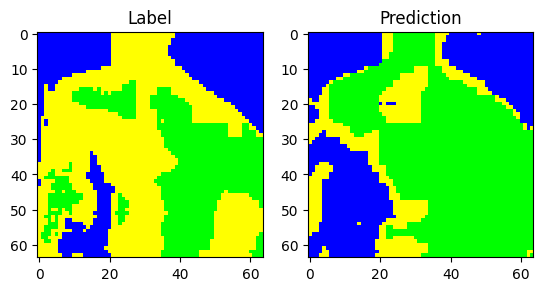

<Figure size 500x300 with 0 Axes>

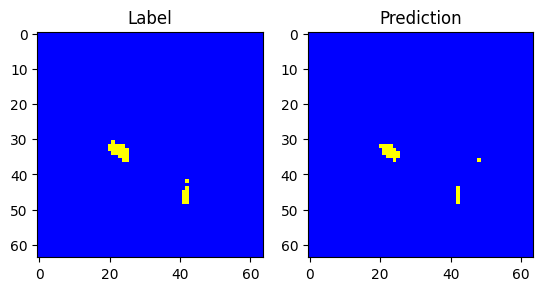

<Figure size 500x300 with 0 Axes>

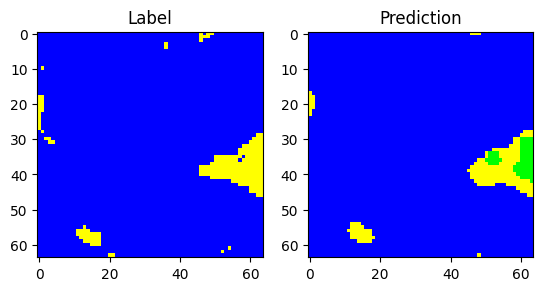

<Figure size 500x300 with 0 Axes>

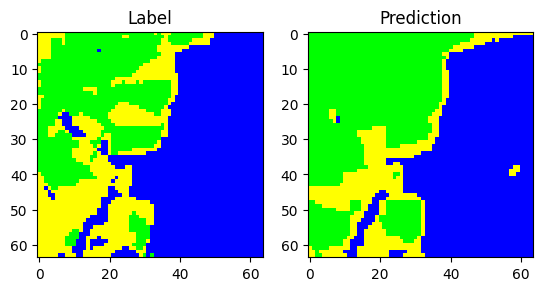

<Figure size 500x300 with 0 Axes>

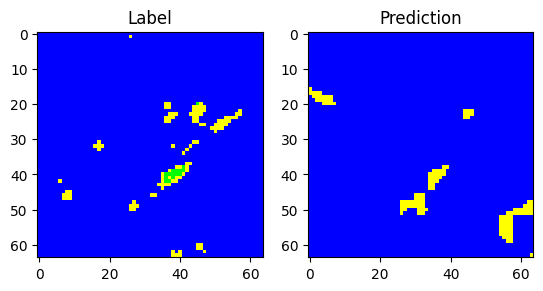

<Figure size 500x300 with 0 Axes>

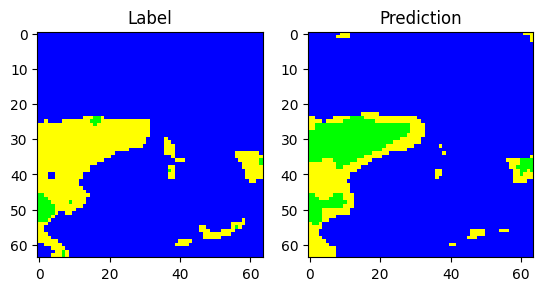

<Figure size 500x300 with 0 Axes>

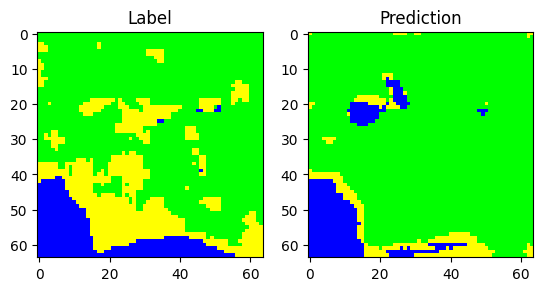

In [22]:
running_acc = 0.0
running_iou = 0.0
SMOOTH = 1e-6

model = Load_model(model_path + "unet_model_rgb_input.pth.tar")

for idx, item in enumerate(test_loader):
    
    image = item[0].to(DEVICE)
    label = item[1]
    
    one_hot_label = one_hot_encoding(label.numpy())
    label = label.to(DEVICE)
    
    output = model(image)
    output = torch.argmax(output, dim=1)

    output_for_metrics = torch.Tensor(one_hot_encoding(output.detach().cpu().numpy())).int()
    label_for_metrics = torch.tensor(one_hot_label)

    # accuaracy metric
    acc = accuracy(output_for_metrics, label_for_metrics)
    running_acc += acc

    # iou metric
    iou = iou_matrix(output_for_metrics, label_for_metrics)
    running_iou += iou

  # Visualization of every 5th image from the test sample
    if idx % 5 == 0:
        fig = plt.figure(figsize=(5, 3))
        image = torch.transpose(image[0], 0, 2).cpu().numpy()

        output = output[13].detach().cpu().numpy()
        output = visualize_label(3, color_dict, output)

        label = label[13].cpu().numpy()  
        label = visualize_label(3, color_dict, label)
        
        fig, ax = plt.subplots(1,2)
        
        ax[0].imshow(label)
        ax[0].set_title('Label')
        ax[1].imshow(output)
        ax[1].set_title('Prediction')
        
        fig.savefig(image_path + 'output_prediction_' + str(idx) + '.png')
        
        if idx == 100:  # To visualize the results on the first few images from the test dataset
            break

mean_acc = running_acc / len(test_loader)  # Mean accuaracy
mean_iou = running_iou / len(test_loader)  # Mean IOU
print("Mean Average Accutacy: "+str(mean_acc)+" Mean IOU: "+str(mean_iou))